In [1]:
dataset="ISL_Dataset"

In [2]:
import os
import cv2
import keras
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from sklearn.utils import shuffle
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import Input, Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"
tf.get_logger().setLevel("ERROR")

In [3]:
x_train = []
y_train = []
image_size = 224
labels = ['a','b','c','d','e','f','g','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','z']
for i in labels:
    folderPath = os.path.join("asl_dataset",i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        x_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('asl_dataset',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        x_train.append(img)
        y_train.append(i)

x_train = np.array(x_train)
y_train = np.array(y_train)

In [4]:
x_train, y_train = shuffle(x_train, y_train, random_state=42)
x_train.shape

(3210, 224, 224, 3)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

C:\Users\dsmat\AppData\Local\Temp\ipykernel_28776\2496448203.py:15: UserWarning: 
The palette list has fewer values (4) than needed (23) and will cycle, which may produce an uninterpretable plot.
  bar_plot = sns.barplot(x='Group', y='Number of Image', hue='Sign Type', data=df, palette=['#7ED321', '#D0021B', '#4A90E2', '#F5A623'])


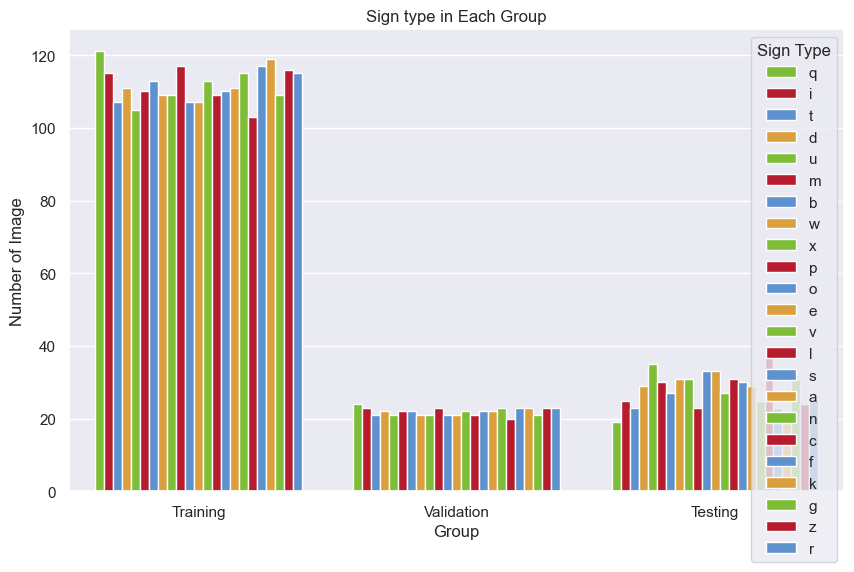

In [6]:
from collections import Counter
train_counts = Counter(Y_train)
val_counts = Counter(Y_train)  
test_counts = Counter(Y_test)
data = {
    'Group': ['Training']*len(train_counts) + ['Validation']*len(train_counts) + ['Testing']*len(test_counts),
    'Sign Type': list(train_counts.keys()) + list(train_counts.keys()) + list(test_counts.keys()),
    'Number of Image': list(train_counts.values()) + [int(v * 0.2) for v in train_counts.values()] + list(test_counts.values())
}

df = pd.DataFrame(data)
plt.figure(figsize=(10, 6))
sns.set(style="darkgrid")

bar_plot = sns.barplot(x='Group', y='Number of Image', hue='Sign Type', data=df, palette=['#7ED321', '#D0021B', '#4A90E2', '#F5A623'])
plt.title('Sign type in Each Group')
plt.xlabel('Group')
plt.ylabel('Number of Image')
plt.show()

In [26]:
print("train shape", X_train.shape, Y_train.shape)
print("test shape", X_test.shape, Y_test.shape)

train shape (2568, 224, 224, 3) (2568,)
test shape (642, 224, 224, 3) (642,)


In [27]:
print(Y_train[:5])
print(Y_test[:5])

['q' 'i' 't' 'd' 'u']
['u' 'd' 's' 'v' 'f']


In [28]:
Y_train

array(['q', 'i', 't', ..., 'g', 'b', 's'], dtype='<U1')

In [42]:
Y_train_list = []
for i in Y_train:
    if i.isdigit():
        Y_train_list.append(int(i))
    else:
        # If i is a lowercase letter, map it to a unique integer
        Y_train_list.append(ord(i) - ord('a'))

# Convert to categorical
y_train1 = tf.keras.utils.to_categorical(Y_train_list)


In [43]:
print("one hot encoding \n", y_train1[:5])

one hot encoding 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0.]]


In [44]:
Y_test[0]

'u'

In [45]:
Y_test_list = []
for i in Y_test:
    if i.isdigit():
        Y_test_list.append(int(i))
    else:
        # If i is a lowercase letter, map it to a unique integer
        Y_test_list.append(ord(i) - ord('a'))

# Convert to categorical
y_test1 = tf.keras.utils.to_categorical(Y_test_list)


In [46]:
y_test1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [47]:
print("one hot encoding \n", y_test1[:5])

one hot encoding 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]]


In [48]:
y_test1[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0.])

In [50]:
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = Flatten(name='flatten')(x)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(26, activation='softmax', name='predictions')(x)

model = Model(inputs=base_model.input, outputs=x)
for layer in base_model.layers:
    layer.trainable = False

In [51]:
import os

# Get the current working directory
current_dir = os.getcwd()

# Define the file path
file_path = os.path.join(current_dir, 'vgg19_model_o8.keras')

checkpoint = ModelCheckpoint(filepath=file_path, monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=1)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=6, verbose=1)

early_stopping = EarlyStopping(monitor='val_accuracy', verbose=1, patience=5)

callbacks = [checkpoint, reduce_learning_rate, early_stopping]


In [52]:
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=["accuracy", "precision", "recall", "auc"])

In [53]:
history = model.fit(X_train, y_train1, epochs=100, batch_size=32, validation_split=0.2, callbacks = callbacks)

Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5931 - auc: 0.8671 - loss: 2.6426 - precision: 0.6651 - recall: 0.5698
Epoch 1: val_loss improved from inf to 0.03920, saving model to d:\SRP\vgg19_model_o8.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.5966 - auc: 0.8685 - loss: 2.6172 - precision: 0.6683 - recall: 0.5735 - val_accuracy: 0.9903 - val_auc: 1.0000 - val_loss: 0.0392 - val_precision: 0.9941 - val_recall: 0.9903 - learning_rate: 1.0000e-05
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9990 - auc: 1.0000 - loss: 0.0043 - precision: 0.9990 - recall: 0.9990
Epoch 2: val_loss improved from 0.03920 to 0.03673, saving model to d:\SRP\vgg19_model_o8.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 310s 5s/step - accuracy: 0.9990 - auc: 1.0000 - loss: 0.0042 - precision: 0.9990 - recall: 0.9990 - val_accuracy: 0.9903 - val_auc: 1.0000 - val_loss: 0.0367 - val_precision: 0.9941 - val_recall: 0.9903 - learning_rate: 1.0000e-05
Epoch 3/100
65/65 ━━━━━━━━

In [54]:
model.save("isl.h5") 


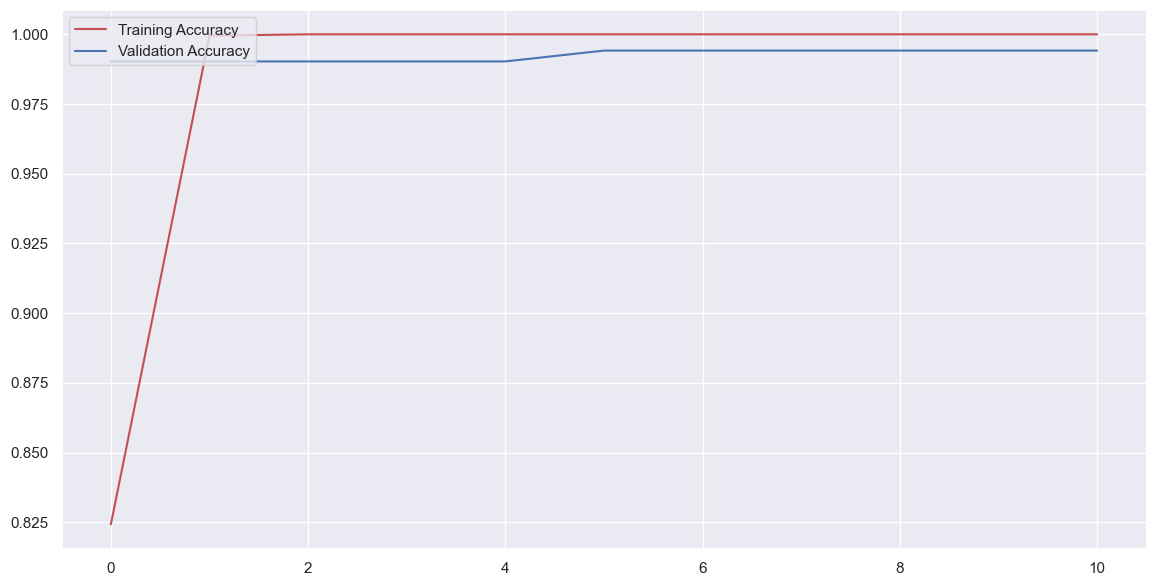

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.legend(loc='upper left')
plt.show()

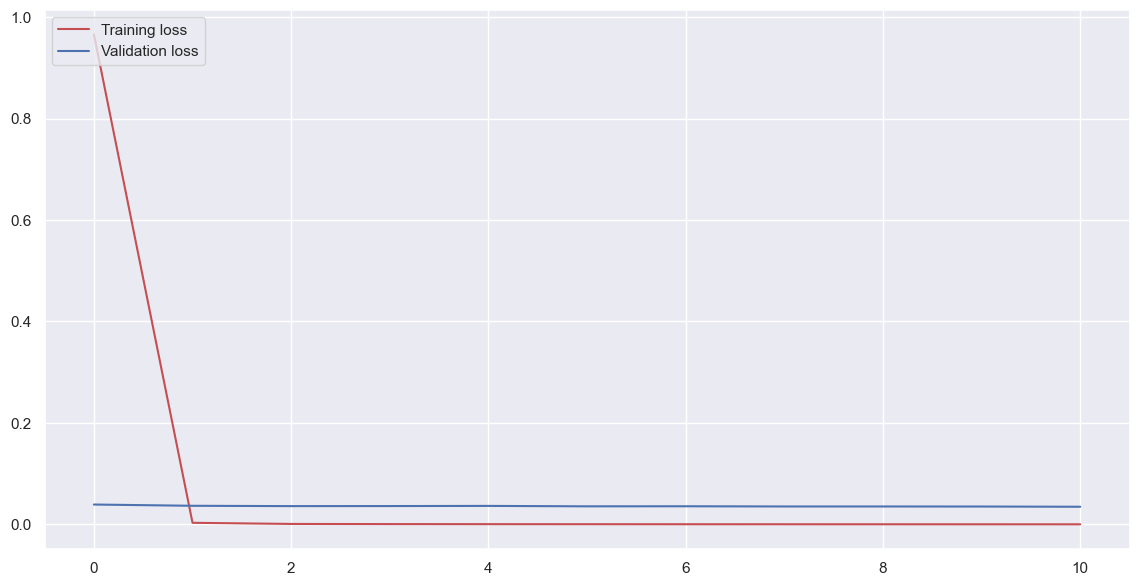

In [57]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,loss,'r',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Validation loss")
plt.legend(loc='upper left')
plt.show()

In [58]:
hist_=pd.DataFrame(history.history)
hist_

,accuracy,auc,loss,precision,recall,val_accuracy,val_auc,val_loss,val_precision,val_recall,learning_rate
0,0.824245,0.960984,0.966046,0.878036,0.809640,0.990272,0.999964,0.039201,0.994141,0.990272,0.00001
1,0.999513,1.000000,0.003189,0.999513,0.999513,0.990272,0.999973,0.036728,0.994141,0.990272,0.00001
2,1.000000,1.000000,0.000935,1.000000,1.000000,0.990272,0.999976,0.036056,0.994141,0.990272,0.00001
3,1.000000,1.000000,0.000657,1.000000,1.000000,0.990272,0.999981,0.036183,0.994141,0.990272,0.00001
4,1.000000,1.000000,0.000521,1.000000,1.000000,0.990272,0.999982,0.036483,0.994141,0.990272,0.00001
5,1.000000,1.000000,0.000433,1.000000,1.000000,0.994163,0.998042,0.035656,0.994141,0.990272,0.00001
6,1.000000,1.000000,0.000367,1.000000,1.000000,0.994163,0.998044,0.035776,0.994141,0.990272,0.00001
7,1.000000,1.000000,0.000317,1.000000,1.000000,0.994163,0.998044,0.035374,0.994141,0.990272,0.00001
8,1.000000,1.000000,0.000277,1.000000,1.000000,0.994163,0.998045,0.035361,0.994141,0.990272,0.00001
9,1.000000,1.000000,0.000245,1.000000,1.000000,0.994163,0.998045,0.035259,0.994141,0.990272,0.00001


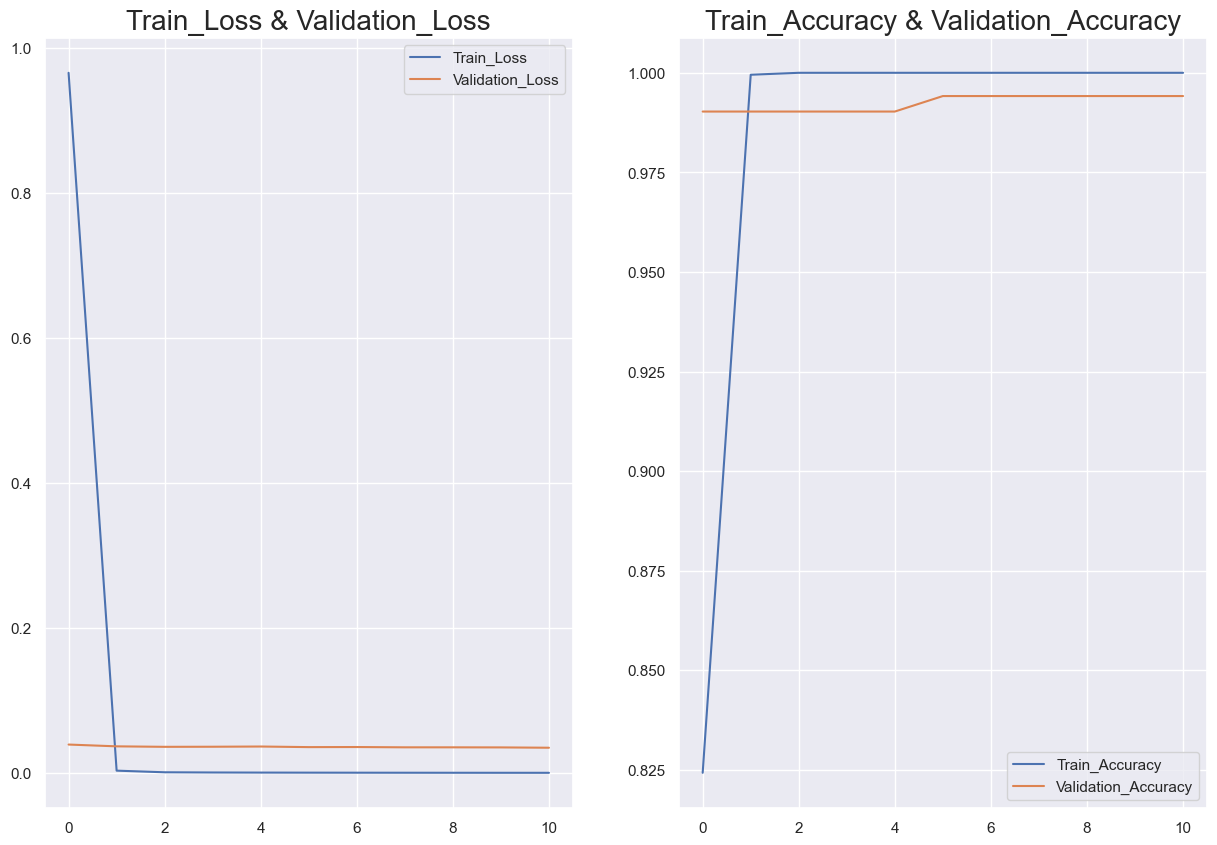

In [59]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [60]:
predic = model.predict(X_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step


In [61]:
y_pred = np.argmax(predic, axis=1)
y_pred = np.ravel(y_pred)



In [62]:
y_pred

array([20,  3, 18, 21,  5, 12, 14,  5,  3, 19,  1, 10, 25, 14,  2,  8, 20,
        0, 23, 13,  4, 11,  1, 18,  6,  4,  5, 25,  3, 12,  4, 25,  8, 21,
       11, 14, 13, 20,  3, 20,  2, 21,  2, 14,  4, 17, 20, 23, 23, 18, 19,
       23, 14, 18,  1,  4, 14, 15, 15, 23,  8, 22, 16, 22,  2, 20,  6, 20,
       22, 20,  8,  6,  2, 15, 21, 13,  2, 12,  6,  4,  3, 20,  1, 17, 11,
       11, 10,  3, 13,  4,  5, 11, 21, 25, 23,  0, 21, 14, 12,  2, 17,  0,
       17, 22, 11, 22, 12,  0, 13,  1, 12, 11,  3, 20,  4,  2, 15, 22,  6,
       22, 14,  3, 15,  3, 16, 21, 22, 12, 20,  2, 16, 20, 10, 25, 18,  8,
       13, 25, 14, 12, 18, 21, 16, 19, 11,  4, 14, 23, 14,  5, 20,  8, 15,
       13,  3, 12,  8, 11, 23, 20, 10,  1,  0,  0, 12,  6,  4,  6, 20,  2,
       15,  4, 19,  0, 19,  2, 17, 22, 14,  3,  1,  8,  3, 22, 21, 20, 21,
       18, 14,  2,  8, 10, 16, 13,  2, 15, 19, 17,  5, 11, 13, 23, 15, 21,
        2, 18, 11,  1, 14, 16, 20, 16,  8, 22, 11, 19,  6,  5,  3, 25, 23,
       21, 23,  1, 23, 21

In [63]:
y_test2 = np.argmax(y_test1, axis=1)
y_test2 = np.ravel(y_test2)

array([[29,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0],
       [ 0, 27,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 37,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 29,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 33,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 31,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 25,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 21,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,

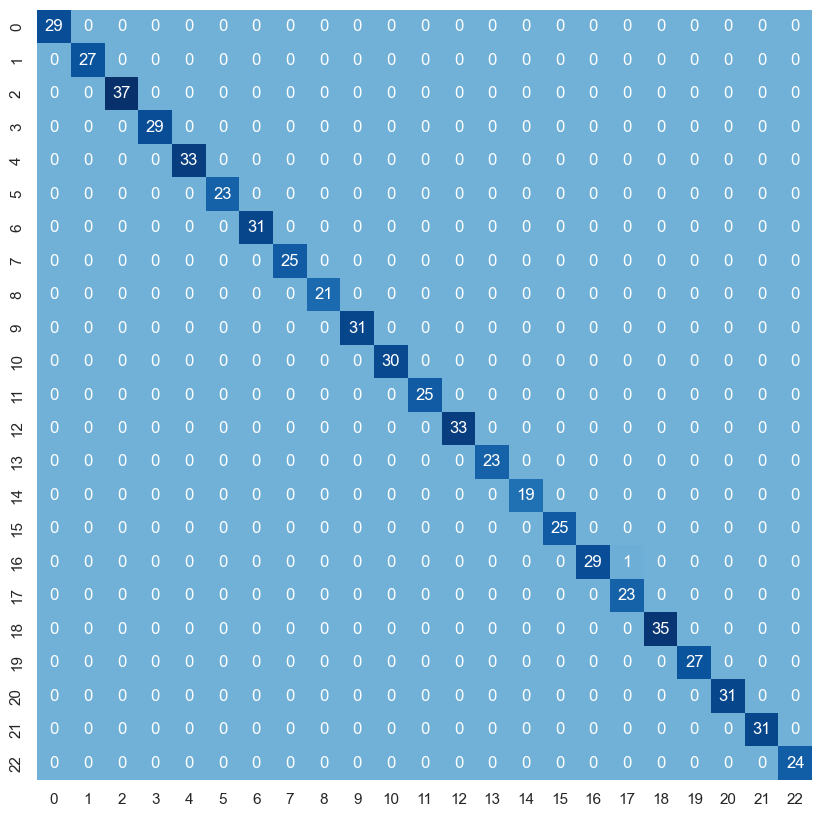

In [66]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(10,10))
CM = confusion_matrix(y_test2,y_pred)
sns.heatmap(CM,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [67]:
from sklearn.metrics import classification_report
ClassificationReport = classification_report(y_test2,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        27
           2       1.00      1.00      1.00        37
           3       1.00      1.00      1.00        29
           4       1.00      1.00      1.00        33
           5       1.00      1.00      1.00        23
           6       1.00      1.00      1.00        31
           8       1.00      1.00      1.00        25
          10       1.00      1.00      1.00        21
          11       1.00      1.00      1.00        31
          12       1.00      1.00      1.00        30
          13       1.00      1.00      1.00        25
          14       1.00      1.00      1.00        33
          15       1.00      1.00      1.00        23
          16       1.00      1.00      1.00        19
          17       1.00      1.00      1.00        25
          18       1.00      0.97      0.98        30

In [69]:
import cv2 

key = cv2. waitKey(1)
webcam = cv2.VideoCapture(0)
while True:
    try:
        check, frame = webcam.read()
        print(check) #prints true as long as the webcam is running
        print(frame) #prints matrix values of each framecd 
        cv2.imshow("Capturing", frame)
        key = cv2.waitKey(1)
        if key == ord('q'): 
            cv2.imwrite(filename='saved_img.jpg', img=frame)
            webcam.release()
            img_new = cv2.imread('saved_img.jpg', cv2.IMREAD_GRAYSCALE)
            img_new = cv2.imshow("Captured Image", img_new)
            cv2.waitKey(1650)
            cv2.destroyAllWindows()
            break

        
    except(KeyboardInterrupt):
        print("Turning off camera.")
        webcam.release()
        print("Camera off.")
        print("Program ended.")
        cv2.destroyAllWindows()
        break

True
[[[118 104 108]
  [118 104 108]
  [119 105 109]
  ...
  [ 99  74  88]
  [ 93  69  84]
  [ 89  65  82]]

 [[118 104 108]
  [118 104 108]
  [119 105 109]
  ...
  [ 86  62  76]
  [ 84  61  76]
  [ 84  60  77]]

 [[117 104 108]
  [117 104 108]
  [118 105 109]
  ...
  [ 81  58  72]
  [ 82  60  76]
  [ 83  61  79]]

 ...

 [[ 93  89 108]
  [ 94  90 109]
  [ 95  91 110]
  ...
  [ 50  38  58]
  [ 50  37  56]
  [ 49  36  55]]

 [[ 92  87 108]
  [ 92  87 108]
  [ 93  88 109]
  ...
  [ 51  37  55]
  [ 52  36  54]
  [ 53  35  54]]

 [[ 91  86 107]
  [ 91  86 107]
  [ 92  87 108]
  ...
  [ 53  38  56]
  [ 55  36  55]
  [ 56  35  54]]]
True
[[[111 100 110]
  [113 102 112]
  [116 104 114]
  ...
  [ 73  62  72]
  [ 69  60  74]
  [ 66  58  75]]

 [[112 101 111]
  [113 102 112]
  [115 104 114]
  ...
  [ 68  55  71]
  [ 65  54  74]
  [ 65  54  76]]

 [[112 102 111]
  [113 103 112]
  [116 105 114]
  ...
  [ 67  50  74]
  [ 67  49  78]
  [ 67  50  81]]

 ...

 [[ 98  94 102]
  [ 98  94 103]
  [ 97  93

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
The predicted label for the input image is: s


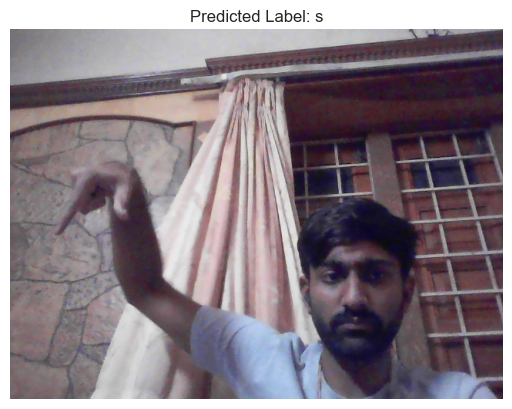

In [70]:
class_labels = 'abcdefgiklmnopqrstuvwxz'

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224,224))  
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    return img_array

def classify_image(image_path):
    img_array = preprocess_image(image_path)
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    predicted_label = class_labels[predicted_class]  
    return predicted_label
image_path = 'saved_img.jpg'  
predicted_label = classify_image(image_path)
print(f'The predicted label for the input image is: {predicted_label}')
img = load_img(image_path)
plt.imshow(img)
plt.title(f'Predicted Label: {predicted_label}')
plt.axis('off')
plt.show()


In [71]:
import pyttsx3
engine = pyttsx3.init()
#used to set speed
engine.setProperty("rate", 100)  
engine.say(predicted_label)  
engine.runAndWait()

In [118]:
### Load saved model 
model2 = load_model("asl.h5")
model2.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,31

 Total params: 139,717,734 (532.98 MB)

 Trainable params: 119,693,348 (456.59 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

 Optimizer params: 2 (12.00 B)

In [1]:
import cv2 

key = cv2. waitKey(1)
webcam = cv2.VideoCapture(0)
while True:
    try:
        check, frame = webcam.read()
        # print(check) #prints true as long as the webcam is running
        # print(frame) #prints matrix values of each framecd 
        cv2.imshow("Capturing", frame)
        key = cv2.waitKey(1)
        if key == ord('q'): 
            cv2.imwrite(filename='saved_img.jpg', img=frame)
            webcam.release()
            img_new = cv2.imread('saved_img.jpg', cv2.IMREAD_GRAYSCALE)
            img_new = cv2.imshow("Captured Image", img_new)
            cv2.waitKey(1650)
            cv2.destroyAllWindows()
            break

        
    except(KeyboardInterrupt):
        print("Turning off camera.")
        webcam.release()
        print("Camera off.")
        print("Program ended.")
        cv2.destroyAllWindows()
        break

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:973: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'cv::imshow'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
The predicted label for the input image is: z


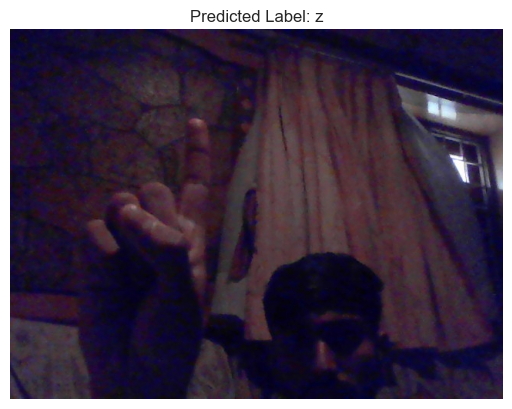

In [120]:
model2 = load_model("asl.h5")
class_labels = '0123456789abcdefghijklmnopqrstuvwxyz'

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224,224))  
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    return img_array

def classify_image(image_path):
    img_array = preprocess_image(image_path)
    prediction = model2.predict(img_array)
    predicted_class = np.argmax(prediction)
    predicted_label = class_labels[predicted_class]  
    return predicted_label
image_path = 'saved_img.jpg'  
predicted_label = classify_image(image_path)
print(f'The predicted label for the input image is: {predicted_label}')
img = load_img(image_path)
plt.imshow(img)
plt.title(f'Predicted Label: {predicted_label}')
plt.axis('off')
plt.show()



In [121]:
import pyttsx3
engine = pyttsx3.init()
#used to set speed
engine.setProperty("rate", 100)  
engine.say(predicted_label)  
engine.runAndWait()

In [ ]:
# for speech to img

In [6]:
import speech_recognition as sr

def speech_to_text():
    # Create a recognizer object
    recognizer = sr.Recognizer()

    # Use the default microphone as the audio source
    with sr.Microphone() as source:
        print("Listening... Speak now!")
        
        # Adjust for ambient noise and listen for audio
        recognizer.adjust_for_ambient_noise(source)
        audio = recognizer.listen(source)

    try:
        # Use Google Speech Recognition to convert audio to text
        text = recognizer.recognize_google(audio)
        print("You said: " + text)
        return text
    except sr.UnknownValueError:
        print("Sorry, I couldn't understand the audio.")
    except sr.RequestError as e:
        print("Could not request results from the speech recognition service; {0}".format(e))

# Call the function
speech_to_text()

Listening... Speak now!
Sorry, I couldn't understand the audio.


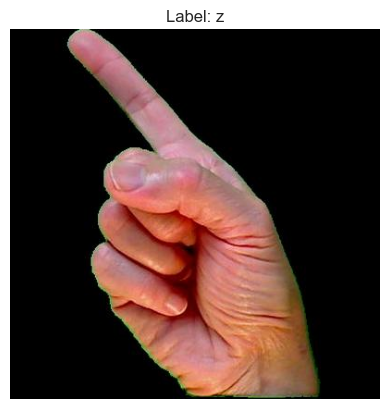

In [122]:
text = 'z'
folderPath = os.path.join("asl_dataset",text)
for j in os.listdir(folderPath):
    img_path = os.path.join(folderPath,j)
    img = load_img(img_path)
    plt.imshow(img)

    plt.title(f'Label: {text}')
    plt.axis('off')
    plt.show()
    break